CARNIELLI Ariana n. 3525837

# Apprentissage de paramètres par maximum de vraisemblance
Dans ce TME, l'objectif est d'apprendre grâce à l'estimateur de maximum de vraisemblance les paramètres de lois normales à partir d'un ensemble de données. Ces lois normales seront ensuite exploitées pour faire de la classification (comme nous l'avions vu en cours avec les images de désert, forêt, mer et paysages enneigés).

Ici, notre base de données d'apprentissage est la base USPS. Celle-ci contient les images réelles de chiffres provenant de codes postaux écrits manuellement et scannés par le service des postes américain. Ces données scannées ont été normalisées de manière à ce qu'elles soient toutes des images de 16x16 pixels en teintes de gris, cf. Le Cun et al., 1990:

Y. LeCun, O. Matan, B. Boser, J. S. Denker, et al. (1990) *Handwritten zip code recognition with multilayer networks*. In ICPR, volume II, pages 35–40.

Voici quelques exemples d'images de cette base : 

<img src="tme3_digit4.jpg" title="4 à la main">&nbsp;<img src="tme3_digit5.jpg" title="5 à la main">&nbsp;<img src="tme3_digit8.jpg" title="8 à la main">

## Préparation / visualisation

Ne perdez pas de temps à essayer de comprendre les instructions de ces fonctions. Leur utilité est décrite en dessous du code. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def read_file ( filename ):
    """
    Lit un fichier USPS et renvoie un tableau de tableaux d'images.
    Chaque image est un tableau de nombres réels.
    Chaque tableau d'images contient des images de la même classe.
    Ainsi, T = read_file ( "fichier" ) est tel que T[0] est le tableau
    des images de la classe 0, T[1] contient celui des images de la classe 1,
    et ainsi de suite.
    """
    # lecture de l'en-tête
    infile = open ( filename, "r" )    
    nb_classes, nb_features = [ int( x ) for x in infile.readline().split() ]

    # creation de la structure de données pour sauver les images :
    # c'est un tableau de listes (1 par classe)
    data = np.empty ( 10, dtype=object )  
    filler = np.frompyfunc(lambda x: list(), 1, 1)
    filler( data, data )

    # lecture des images du fichier et tri, classe par classe
    for ligne in infile:
        champs = ligne.split ()
        if len ( champs ) == nb_features + 1:
            classe = int ( champs.pop ( 0 ) )
            data[classe].append ( list ( map ( lambda x: float(x), champs ) ) )
    infile.close ()

    # transformation des list en array
    output  = np.empty ( 10, dtype=object )
    filler2 = np.frompyfunc(lambda x: np.asarray (x), 1, 1)
    filler2 ( data, output )

    return output

def display_image ( X ):
    """
    Etant donné un tableau X de 256 flotants représentant une image de 16x16
    pixels, la fonction affiche cette image dans une fenêtre.
    """
    # on teste que le tableau contient bien 256 valeurs
    if X.size != 256:
        raise ValueError ( "Les images doivent être de 16x16 pixels" )

    # on crée une image pour imshow: chaque pixel est un tableau à 3 valeurs
    # (1 pour chaque canal R,G,B). Ces valeurs sont entre 0 et 1
    Y = X / X.max ()
    img = np.zeros ( ( Y.size, 3 ) )
    for i in range ( 3 ):
        img[:,i] = Y

    # on indique que toutes les images sont de 16x16 pixels
    img.shape = (16,16,3)

    # affichage de l'image
    plt.imshow( img )
    plt.show ()

Nous utiliserons la base `usps_train.txt`. La fonction `read-file:str->float np.array np.array` ci-dessus permet de lire ce fichier. La fonction renvoie un tableaux d'images vérifiant :
- Chaque image a une taille de 16x16 pixels et représente un chiffre entre 0 et 9 (comme les images ci-dessus).
- Chaque image est modélisée par un tableau numpy de 256 nombres réels compris entre 0 et 2, qui caractérisent l'intensité des pixels dans l'image ($16x16 = 256$ pixels). 
- Les images correspondant au même chiffre manuscript (0,...,9) sont placées dans un même tableau. Le fichier `usps` indique en effet pour chaque image à quel chiffre celle-ci correspond. Dans le jargon de l'apprentissage, les chiffres sont appelés classes et, lorsque nous aurons de nouvelles images dont nous essayerons de déterminer, grâce à nos lois normales, à quel chiffre elles correspondent, nous dirons que nous faisons de la classification. Enfin, apprendre les paramètres de nos lois normales à partir d'un fichier qui contient pour chaque image sa classe s'appelle de l'apprentissage supervisé.
- Pour terminer la description de l'objet retourné par la fonction `read_file`, les tableaux d'images correspondant à chaque chiffre sont eux-mêmes stockés dans un tableau et c'est ce dernier qui est renvoyé. Chaque élément de ce tableau correspond donc à l'ensemble des images d'une classe. Le premier élément contient ainsi toutes les images du chiffre 0, le 2ème toutes celles du chiffre 1, et ainsi de suite. Par exemple, si `read_file("fichier")` retourne un objet `training_data`, alors `training_data[2]` est le tableau de toutes les images du chiffre 2, et `training_data[2][3]` correspond à la 4ème image du chiffre 2 (les indices des tableaux débutant à 0), autrement dit à un tableau de $256$ nombres réels représentant cette image. 

La fonction `display_image`, quant à elle, permet de visualiser les images que vous allez manipuler. Celle-ci prend donc en argument une image (c'est-à-dire un tableau de 256 nombres réels) et l'affiche dans une fenêtre. Exécutez cette fonction sur quelques images de votre base d'apprentissage afin de visualiser les données que vous allez manipuler par la suite. Par exemple, vous pouvez tester: 

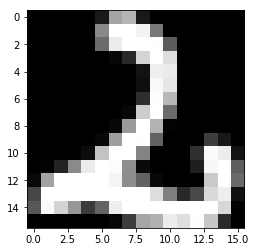

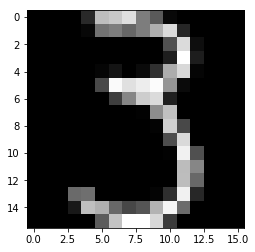

In [84]:
training_data = read_file ("usps_train.txt")

# affichage du 1er chiffre "2" de la base:
display_image (training_data[2][0])

# affichage du 5ème chiffre "3" de la base:
display_image (training_data[3][4])


1- Maximum de vraisemblance pour une classe
Nous allons étudier la distribution de probabilité des teintes de gris des images (en fait, nous allons étudier sa fonction de densité car on travaille sur des variables aléatoires continues) . Nous allons faire l'hypothèse (certes un peu forte mais tellement pratique) que, dans chaque classe, les teintes des pixels sont mutuellement indépendantes. 

Autrement dit, si $X_i, i\in \{0,...,255\}$ représente la variable aléatoire "intensité de gris du ième pixel", alors $p(X_0,…,X_{255})$ représente la fonction de densité des teintes de gris des images de la classe et: 

$$p(X_0,,…,X_{255})=\prod_{i=0}^{255} p(X_i)$$

Ainsi, en choisissant au hasard une image dans l'ensemble de toutes les images possibles de la classe, si celle-ci correspond au tableau `np.array([x_0,...,x_255])`, où les $x_i$ sont des nombres réels compris entre 0 et 2, alors la valeur de la fonction de densité de l'image est égale à $p(x_0,...,x_{255}) = \prod^{255}_{i=0}p(x_i)$. 

Nous allons de plus supposer que chaque $X_i$ suit une distribution normale de paramètres $(μ_i,σ^2_i)$. Autrement dit, $$\forall i\in\{0,...,255\}, X_i \sim {\cal N}(μ_i,σ^2_i)$$ 

Par maximum de vraisemblance, estimez, pour une classe donnée, l'ensemble des paramètres $(μ_0,…,μ_{255}) et (σ^2_0,…,σ^2_{255})$. Pour cela, écrivez une fonction `learnML_class_parameters : float np.array np.array -> float np.array x float np.array` qui, étant donné le tableau d'images d'une classe tel que retourné par la fonction read_file (autrement dit un tableau de tableaux de 256 nombres réels), renvoie un couple de tableaux, le premier élément du couple correspondant à l'ensemble des $μ_i$ et le 2ème à l'ensemble des $σ^2_i$. C'est-à-dire que `learnML_class_parameters ( classe )` renverra un objet similaire à :

```( array ( [μ0,…,μ255] ), array ( [σ20,…,σ2255] ) )```

Grâce à votre fonction `learnML_class_parameters`, vous pourrez ainsi vérifier que, en utilisant `learnML_class_parameters ( training_data[0] )`, vous allez pouvoir calculer le tableau de paramètres suivant~:

```
 (array([ 1.37185930e-03,   4.60217755e-03,   1.50770519e-02,
          5.87487437e-02,   1.66657454e-01,   4.28577052e-01,
          8.68415410e-01,   1.15260804e+00,   1.04628392e+00,
          6.46298995e-01,   2.58751256e-01,   7.90837521e-02,
          ...............................
          1.28302848e+00,   1.52802513e+00,   1.43905193e+00,
          1.04248827e+00,   5.32985762e-01,   1.74494137e-01,
          3.24891122e-02,   3.47487437e-03,   6.36515913e-05,
          0.00000000e+00]), 
  array([ 2.24522353e-03,   6.60664324e-03,   1.95906222e-02,
          6.29011999e-02,   1.80366523e-01,   3.72113773e-01,
          5.31683397e-01,   5.38201451e-01,   5.62586277e-01,
          4.57620803e-01,   2.35928060e-01,   8.26775407e-02,
          ...............................
          4.46902042e-01,   3.40271867e-01,   1.30177809e-01,
          2.49171310e-02,   1.77752743e-03,   4.23882955e-06,
          0.00000000e+00] ) )
```

et `learnML_class_parameters ( training_data[1] )` devrait rendre
```
 (array([ 0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.98009950e-06,   1.27223881e-02,
          3.64843781e-01,   1.47724776e+00,   9.99703483e-01,
          1.18331343e-01,   4.97313433e-03,   0.00000000e+00,
          ...............................
          4.32477612e-01,   3.99064677e-02,   3.73731343e-03,
          6.62686567e-04,   4.67661692e-04,   0.00000000e+00,
          0.00000000e+00]), 
  array([ 0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.59045568e-08,   7.47939656e-03,
          2.52206480e-01,   2.13186449e-01,   3.40351753e-01,
          7.76266554e-02,   3.64318435e-03,   0.00000000e+00,
          ...............................
          3.20651061e-01,   4.13332529e-02,   4.10675488e-03,
          4.40910100e-04,   2.19582288e-04,   0.00000000e+00,
          0.00000000e+00] ) )
```

In [4]:
def learnML_class_parameters(tab_img):
    return np.mean(tab_img, 0), np.var(tab_img, 0)

In [6]:
learnML_class_parameters(training_data[0])

(array([1.37185930e-03, 4.60217755e-03, 1.50770519e-02, 5.87487437e-02,
        1.66657454e-01, 4.28577052e-01, 8.68415410e-01, 1.15260804e+00,
        1.04628392e+00, 6.46298995e-01, 2.58751256e-01, 7.90837521e-02,
        1.49748744e-02, 2.81742044e-03, 6.53266332e-05, 0.00000000e+00,
        1.76549414e-03, 6.53433836e-03, 5.00293132e-02, 1.88505863e-01,
        5.10424623e-01, 1.06171608e+00, 1.52639280e+00, 1.68250000e+00,
        1.63088945e+00, 1.39957621e+00, 9.51082915e-01, 4.20636516e-01,
        1.27508375e-01, 3.08886097e-02, 3.20016750e-03, 5.02512563e-06,
        3.31825796e-03, 2.71273032e-02, 1.36604690e-01, 4.37097152e-01,
        9.42998325e-01, 1.43772194e+00, 1.62785260e+00, 1.61645645e+00,
        1.55001340e+00, 1.51951173e+00, 1.37973953e+00, 9.38602178e-01,
        4.34310720e-01, 1.22752094e-01, 2.15100503e-02, 1.88525963e-03,
        6.25460637e-03, 6.85695142e-02, 3.10753769e-01, 7.81501675e-01,
        1.29654858e+00, 1.53751340e+00, 1.44771859e+00, 1.211631

In [5]:
learnML_class_parameters(training_data[1])

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.98009950e-06, 1.27223881e-02, 3.64843781e-01, 1.47724776e+00,
        9.99703483e-01, 1.18331343e-01, 4.97313433e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.11442786e-04, 2.29164179e-02, 4.97605970e-01, 1.80326368e+00,
        1.68735622e+00, 3.85793035e-01, 2.02776119e-02, 3.90049751e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.14427861e-03, 2.39064677e-02, 5.16177114e-01, 1.84452239e+00,
        1.83539502e+00, 5.21406965e-01, 3.97134328e-02, 4.73631841e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.98009950e-04,
        2.14825871e-03, 2.78109453e-02, 5.24138308e-01, 1.843859

## 2- Maximum de vraisemblance
En utilisant la fonction de la question précédente, écrivez une fonction `learnML_all_parameters : float np.array np.array np.array -> (float np.array x float np.array) list` qui, étant donné le tableau `training_data` retourné par la fonction `read_file` (donc contenant toutes les images de toutes les classes), renvoie une liste de couples `( array ( [μ0,…,μ255] ), array ( [σ20,…,σ2255] ) )`. Vous exécuterez cette fonction sur vos données d'apprentissage et sauvegarderez le résultat dans une variable `parameters`.

In [7]:
def learnML_all_parameters(tab_classes):
    return [learnML_class_parameters(x) for x in tab_classes]

parameters=learnML_all_parameters(training_data)

## 3- Log-vraisemblance d'une image
Nous allons maintenant tester si, étant donné de nouvelles images, on peut classer celles-ci correctement, c'est-à-dire si on peut retrouver les chiffres auxquelles elles correspondent vraisemblablement. Pour cela, nous allons utiliser de nouvelles images se trouvant dans le fichier `usps_test.txt`. Ce fichier a exactement le même format que celui d'apprentissage et peut donc être lu grâce à la fonction `read_file`. En particulier, pour chaque image, nous avons le chiffre auquel elle correspond, ce qui nous permettra de vérifier que notre classifieur fonctionne correctement. Lisez-le dans la variable `test_data` en utilisant `read_file`.

In [8]:
# votre code
test_data = read_file("usps_test.txt")

Écrivez une fonction `log_likelihood : float np.array x (float np.array,np.array) -> float` qui, étant donné une image (donc un tableau de 256 nombres réels) et un couple de paramètres `( array ( [μ0,…,μ255] ), array ( [σ20,…,σ2255] ) )`, renvoie la log-vraisemblance qu'aurait l'image selon cet ensemble de $μ_i$ et $σ_i$. Rappelez-vous que (en mettant $-\frac{1}{2}$ en facteur) : 

$$\log(p(x_0,\cdots,x_{255})=\sum_{i=0}^{255} \log p(x_i)=-\frac{1}{2}\sum_{i=0}^{255} \left[ \log(2\pi \sigma^2_i) + \frac{(x_i-\mu_i)^2}{\sigma_i^2} \right]$$

Notez que le module `math` contient une constante `math.pi`. 

**Attention**: dans la liste `parameters` calculée dans la question précédente, pour certains pixels de certaines classes, la valeur de $σ^2$ est égale à $0$ (toutes les images de la base d'apprentissage avaient exactement la même valeur sur ce pixel). Dans ce cas, la vraisemblance de toute image sur ce pixel doit être de $1$ (et donc sa log-vraisemblance doit être égale à $0$). 

In [9]:
def log_likelihood(img,params):
    # votre code
    pass

def log_likelihood(img, class_params):
    mu, sigma2 = class_params
    valides = (sigma2 != 0)
    tab_log = -1 / 2 * np.log(2 * np.pi * sigma2[valides]) - 1 / 2 * (img[valides] - mu[valides])**2 / sigma2[valides]
    return tab_log.sum()

Soit le code :
```
[ log_likelihood ( test_data[0][0], parameters[i] ) for i in range ( 10 ) ]
```

Il va calculer pour toutes les classes, la log-vraisemblance de la première image de test de classe $0$. Son résultat devrait être :
```
 [-80.594309481001218, -2030714328.0707991, -339.70961551873495, -373.97785273732529,
  -678.16479308314922, -364.62227994586954, -715.4508284953547,  -344286.66839952325,
  -499.88159107145611, -35419.208662902507]
```

Qu'en conclure ?

On voit que la fonction retourne bien le résultat donné :

In [11]:
print(np.allclose([log_likelihood(test_data[0][0], parameters[i]) for i in range(10)], \
                        [-80.594309481001218, -2030714328.0707991, -339.70961551873495, \
                         -373.97785273732529, -678.16479308314922, -364.62227994586954, \
                         -715.4508284953547,  -344286.66839952325, -499.88159107145611, \
                         -35419.208662902507]))

True


On conclut que la log-vraisemblance est maximale pour les paramètres de la classe 0, où elle vaut -80.59. En faisant une classification par le maximum de la log-vraisemblance, on arrive donc à identifier correctement l'image comme étant un 0.

## 4- Log Vraisemblance (bis)
Écrivez une fonction `log_likelihoods : float np.array x (float np.array,np.array) list -> float np.array` qui, étant donné une image (donc un tableau de 256 nombres réels) et la liste de paramètres déterminés dans la question 3 (la variable `params`), renvoie un tableau contenant, pour chaque chiffre possible entre $0$ et $9$, la log-vraisemblance qu'aurait l'image si celle-ci correspondait à ce chiffre. Ainsi, si `tab = log_likelihoods ( image, parameters )`, `tab` est un tableau de 10 éléments (les 10 chiffres possibles) et `tab[3]` est égal à la log-vraisemblance de l'image dans la classe "chiffre = 3".

Vous pourrez vérifier que vous obtenez les mêmes résultats que ci-dessous pour l'appel `log_likelihoods ( test_data[1][5], parameters )` : 

```
array([-889.22508387,  184.03163176, -185.29589129, -265.13424326,
        -149.54804688, -215.85994204,  -94.86965712, -255.60771575,
        -118.95170104,  -71.5970028 ])
```

In [12]:
def log_likelihoods(img, params):
    return np.array([log_likelihood(img, p) for p in params])

On vérifie bien qu'on trouve les résultats donnés :

In [13]:
print(log_likelihoods(test_data[1][5], parameters))
print(np.allclose(log_likelihoods(test_data[1][5], parameters), \
        np.array([-889.22508387,  184.03163176, -185.29589129, -265.13424326, \
        -149.54804688, -215.85994204,  -94.86965712, -255.60771575, \
        -118.95170104,  -71.5970028 ])))

[-889.22508387  184.03163176 -185.29589129 -265.13424326 -149.54804688
 -215.85994204  -94.86965712 -255.60771575 -118.95170104  -71.5970028 ]
True


## 5- Classification d'une image
Écrire une fonction `classify_image : float np.array x (float np.array,np.array) list -> int` qui, étant donnée une image et l'ensemble de paramètres déterminés dans les questions précédentes, renvoie la classe la plus probable de l'image, c'est-à-dire celle dont la log-vraisemblance est la plus grande.

Vous pourrez vérifier que vous obtenez les mêmes résultats que ci-dessous: 

`classify_image( test_data[1][5], parameters )`
```
1
```

`classify_image( test_data[4][1], parameters )`
```
9
```

In [14]:
def classify_image(img, params):
    return log_likelihoods(img, params).argmax()

On vérifie bien qu'on trouve les résultats donnés :

In [15]:
print(classify_image(test_data[1][5], parameters))
print(classify_image(test_data[4][1], parameters))

1
9


# Partie optionnelle
## 6- Classification de toutes les images
Écrire une fonction `classify_all_images : float np.array np.array np.array x (np.array,np.array) list -> float np.2D-array` qui, étant donné le tableau `test_data` des images du fichiers `usps_test.txt` tel que retourné par la fonction `read_fie` et l'ensemble de paramètres déterminés dans les questions précédentes, renvoie un tableau numpy bi-dimensionne `T `de taille 10x10 tel que `T[i,j]` représente le pourcentage d'images correspondant dans la réalité au chiffre $i$ que votre classifieur a classées dans la classe $j$ ($\forall i, \sum^9_{j=0} T[i,j] = 1.0$).

Vous pourrez vérifier que:
```
    T[0,0] = 0.84958217
    T[2,3] = 0.040404040404040407
    T[5,3] = 0.050000000000000003 
```

In [16]:
def  classify_all_images(tab_img, params):
    T = np.zeros((10,10))
    for i in range(tab_img.size):
        for img in tab_img[i]:
            T[i, classify_image(img, params)] += 1
        T[i, :] /= T[i, :].sum()
    return T

On vérifie bien qu'on trouve les résultats donnés :

In [18]:
T = classify_all_images(test_data, parameters)
print(T[0, 0])
print(T[2, 3])
print(T[5, 3])

print(np.allclose([T[0, 0], T[2, 3], T[5, 3]], [0.84958217, 0.040404040404040407, 0.050000000000000003]))

0.8495821727019499
0.04040404040404041
0.05
True


## 7-Affichage du résultat des classifications
Afin de visualiser les résultats obtenus par votre classifieur, ex&cuter la fonction suivante, qui prend en paramètres le tableau obtenu à la question précédente. 

Si votre classifieur est performant, vous devriez observer des pics sur la diagonale.

<img src="tme3_classified.jpg" title="résultats de classification">

In [19]:
from mpl_toolkits.mplot3d import Axes3D

def dessine (classified_matrix):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.linspace (0, 9, 10)
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, classified_matrix, rstride = 1, cstride=1)
    
def dessine_bis(classified_matrix):
    fig, ax = plt.subplots()
    x = y = np.linspace (0, 9, 10)
    X, Y = np.meshgrid(x, y)
    mappable = ax.contourf(X, Y, classified_matrix)
    fig.colorbar(mappable)

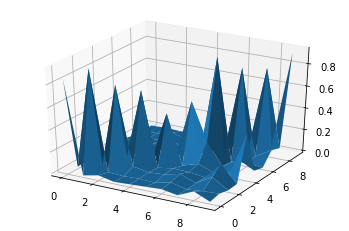

In [22]:
dessine(T)

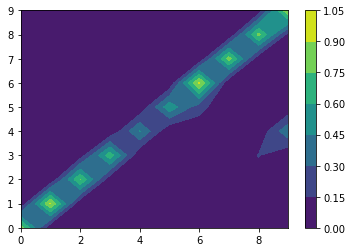

In [23]:
dessine_bis(T)

## 8- Classification versus génération
Les paramètres calculés spécifient complètement le modèle pour chacune des classes. Générer aléatoirement une série de $3$ images pour chaque classe de $0$ à $9$ (donc 30 images). Comparer leurs log-vraisemblances dans leurs classes par rapport à celles des 'vraies' images (également dans leurs classes).

Qu'en concluez-vous ?

In [166]:
print(training_data.shape)
print(training_data[2].shape)
print(training_data[2][0].shape)

(10,)
(731, 256)
(256,)


In [174]:
alea = np.empty_like(training_data)

for i in range(alea.size):
    alea[i] = np.empty((3, 256))


for i in range(alea.size):
    for j in range(3):
        alea[i][j] = np.array(np.random.normal(parameters[i][0], parameters[i][1]))

Comme attendu, on arrive a bien classifier toutes les images crées en utilisant la loi normale et les paramètres calculés par la fonction learnML_all_parameters appliquée à training_data.

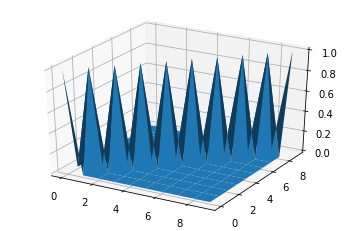

In [175]:
dessine(classify_all_images(alea, parameters))

Si l'on prend un chiffre qui était déjà bien classifié, comme 0, on remarque que la log-vraisemblance est assez similaire pour les données de test et la figure créée aléatoirement (de l'ordre de -80). 

In [186]:
print(log_likelihoods(test_data[0][2], parameters))
print(log_likelihoods(alea[0][2], parameters))

[-8.20631271e+01 -2.02712549e+09 -3.05691268e+02 -3.02680123e+02
 -4.13825739e+02 -2.31179542e+02 -4.60994244e+02 -2.80468954e+04
 -2.53478544e+02 -1.51470501e+04]
[-9.02921754e+01 -3.78684691e+07 -3.84555808e+02 -5.93199358e+02
 -4.44542231e+02 -3.15028506e+02 -1.00218636e+03 -4.51887122e+04
 -1.01960631e+03 -3.25395041e+04]


Par contre, pour des chiffres dont la classification n'était pas très bonne, comme le 6, il y a une différence importante entre la log-vraisemblance de l'image aléatoire et la log-vraisemblance d'une donnée de test : celle de l'image aléatoire est beaucoup plus grande. Cela indiquerait que le modèle n'a pas réussi à bien capturer toute l'information pour reconnaître ce chiffre (car il s'agit d'un modèle très simple, notamment à cause de l'hypothèse d'indépendance).

In [181]:
print(log_likelihoods(test_data[6][0], parameters))
print(log_likelihoods(alea[6][0], parameters))

[-5.06347601e+02 -4.11154359e+07 -4.09100327e+02 -1.02878485e+03
 -1.03598542e+03 -6.21399534e+02 -2.90320156e+02 -4.48702155e+04
 -4.66026842e+03 -1.18485001e+05]
[-2.23596298e+02 -7.82379794e+08 -1.90378273e+02 -2.52735242e+02
 -6.01312363e+02 -1.73159239e+02  2.39079760e+01 -3.28982377e+04
 -1.90824646e+02 -8.66794644e+03]


On peut voir que l'image ne resemble pas beaucoup a l'image réel du chiffre 6 de test_data[6][0]:

In [184]:
def display_corrige(img):
    img_copy = np.where(img < 0, 0, img)
    display_image(img_copy)

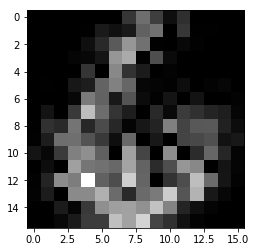

In [188]:
display_corrige(alea[6][0])

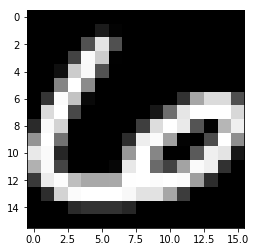

In [189]:
display_corrige(test_data[6][0])